# BBC News Classification - ( Part 1 of  Assignment )

__Part 2 can be found at the end of the book.__

## GitHub Repository

https://github.com/jagrat89/BBCNewsClassification

## Imports

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import mode
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import NMF

## EDA and Visaulization

### Loading the Dataset

In [3]:
file_path = './BBC News Train.csv'
bbc_news_data = pd.read_csv(file_path)

bbc_news_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [23]:
bbc_news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Article Length  1490 non-null   int64 
 4   Word Count      1490 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 58.3+ KB


There are __1490__ articles in the test dataset.

### Summary of the Dataset

In [4]:
summary = {
    'Total Articles': bbc_news_data['ArticleId'].nunique(),
    'Total Categories': bbc_news_data['Category'].nunique(),
    'Articles per Category': bbc_news_data['Category'].value_counts(),
    'Missing Values': bbc_news_data.isnull().sum(),
    'Data Types': bbc_news_data.dtypes
}

summary

{'Total Articles': 1490,
 'Total Categories': 5,
 'Articles per Category': sport            346
 business         336
 politics         274
 entertainment    273
 tech             261
 Name: Category, dtype: int64,
 'Missing Values': ArticleId    0
 Text         0
 Category     0
 dtype: int64,
 'Data Types': ArticleId     int64
 Text         object
 Category     object
 dtype: object}

1. There are a total of 1,490 unique articles.
2. The dataset contains 5 unique categories.
3. There are no missing values in the dataset.

### Distribution of Articles

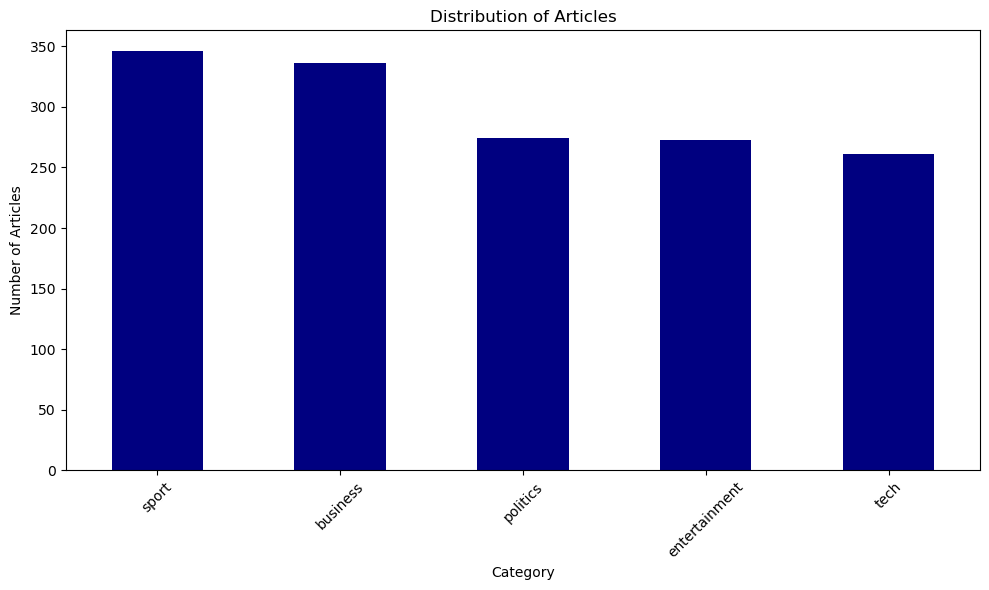

In [10]:
plt.figure(figsize=(10, 6))
bbc_news_data['Category'].value_counts().plot(kind='bar', color='navy')
plt.title('Distribution of Articles')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of Article Lengths by Category

<Figure size 1200x700 with 0 Axes>

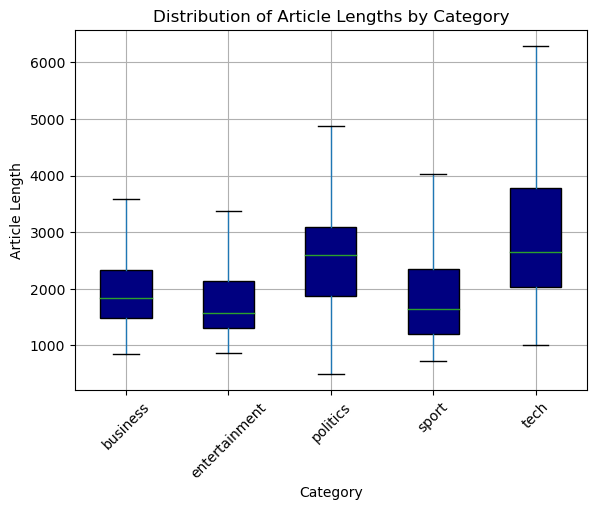

In [21]:
bbc_news_data['Article Length'] = bbc_news_data['Text'].apply(len)

plt.figure(figsize=(12, 7))
boxplot = boxplot = bbc_news_data.boxplot(
    column='Article Length',
    by='Category',
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='navy')
)
plt.title('Distribution of Article Lengths by Category')
plt.suptitle('') 
plt.xlabel('Category')
plt.ylabel('Article Length')
plt.xticks(rotation=45)
plt.show()

Aritcles of the Politics and tech category have the highest mean length, and Article of the tech category have the highest variance for article length. 

### Histogram of Article Lengths

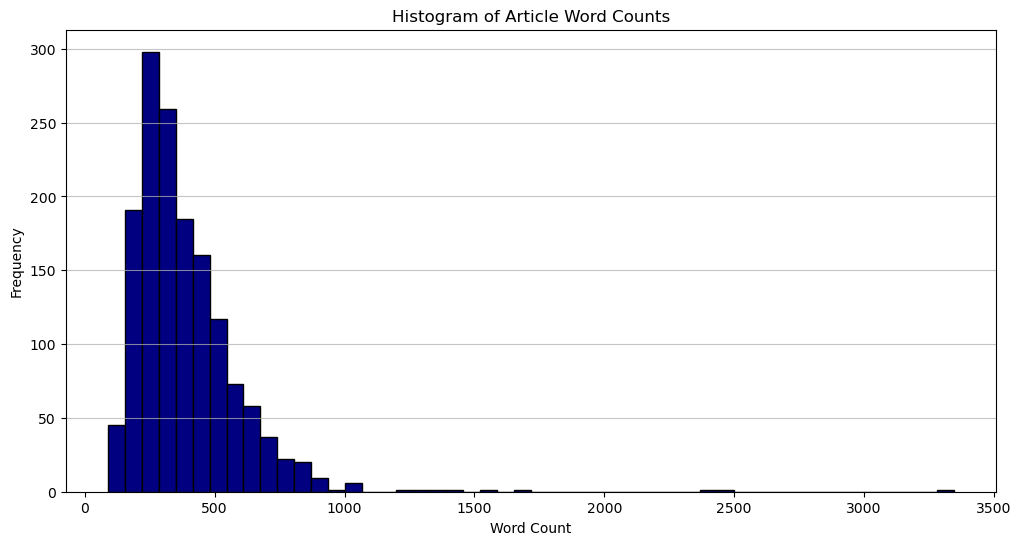

In [16]:
bbc_news_data['Word Count'] = bbc_news_data['Text'].apply(lambda text: len(text.split()))

plt.figure(figsize=(12, 6))
plt.hist(bbc_news_data['Word Count'], bins=50, color='navy', edgecolor='black')
plt.title('Histogram of Article Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The word count distribtuion of the Article is very close to an exponential distribution.

### Word Cloud for All Articles

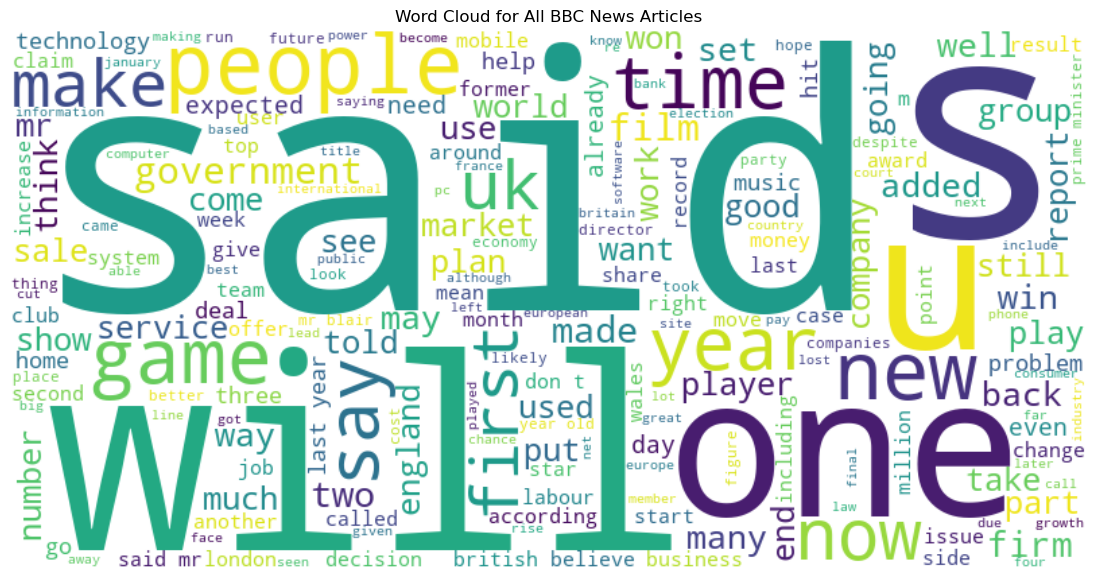

In [20]:
all_text = ' '.join(bbc_news_data['Text'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud for All BBC News Articles')
plt.show()

__Said__ and __Will__ seem to be one of the most used words in the Articles.

## Text Preprocessing

I will use __TF-IDF__ (Term Frequency-Inverse Document Frequency) for converting the data to matrix form.

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                   min_df=2, stop_words='english',
                                   use_idf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(bbc_news_data['Text'])

## Model Building

### Factorizing the Matrix

I will keep the number topics to be equal to the number of article categories which is __5__.

In [27]:
n_components = bbc_news_data['Category'].nunique()
lf_model = TruncatedSVD(n_components=n_components)
lf_pipeline = make_pipeline(lf_model, Normalizer(copy=False))
X_train_lf = lf_pipeline.fit_transform(X_train_tfidf)
X_train_lf.shape

(1490, 5)

### K-Means Clustering Model for Prediction

In [69]:
kmeans_model = KMeans(n_clusters=n_components, random_state=42, n_init=10)

train_clusters = kmeans_model.fit_predict(X_train_lf)

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(bbc_news_data['Category'])

mapped_labels = np.zeros_like(train_clusters)
for i in range(n_components):
    mask = (train_clusters == i)
    mapped_labels[mask] = mode(true_labels[mask], keepdims=True)[0]

confusion_mat = confusion_matrix(true_labels, mapped_labels)
train_accuracy = accuracy_score(true_labels, mapped_labels)

#### Training Result

The accuracy of the training model is 0.9275167785234899


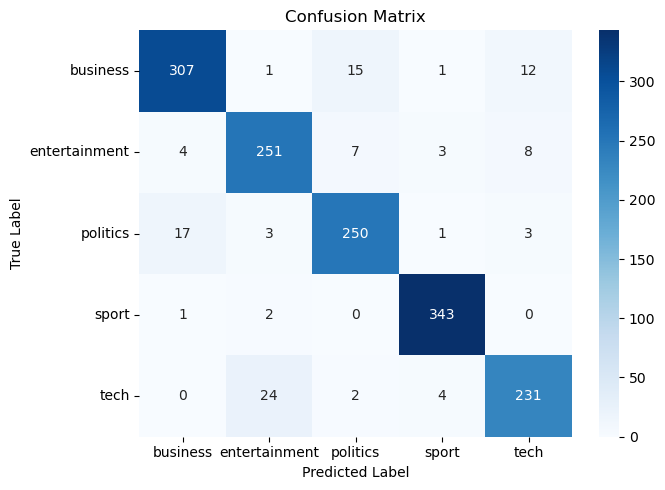

In [70]:
def plot_confusion_matrix(confusion_mat, classes, title='Confusion Matrix'):
    plt.figure(figsize=(7, 5))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

class_names = label_encoder.classes_

plot_confusion_matrix(confusion_mat, class_names)

print(f"The accuracy of the training model is {train_accuracy}")

The accuracy of the clustering on the training data is approximately 92.55%.

### Kaggle Test Result

In [52]:
def generate_submission(model, vectorizer, lf_pipeline, label_encoder, n_components,test_filepath, sample_submission_filepath, output_filepath):
    test_data = pd.read_csv(test_filepath)
    X_test_tfidf = vectorizer.transform(test_data['Text'])
    n_components = bbc_news_data['Category'].nunique()
    X_test_lf = lf_pipeline.transform(X_test_tfidf)
    test_clusters = model.predict(X_test_lf)
    test_labels = label_encoder.inverse_transform(test_clusters)
    sample_submission = pd.read_csv(sample_submission_filepath)
    sample_submission['Category'] = test_labels
    sample_submission.to_csv(output_filepath, index=False)
    

test_filepath = './BBC News Test.csv'
sample_submission_filepath = './BBC News Sample Solution.csv'
output_filepath = './submission.csv'

generate_submission(
    model=kmeans_model,
    vectorizer=tfidf_vectorizer,
    lf_pipeline = lf_pipeline,
    label_encoder = label_encoder,
    n_components = n_components,
    test_filepath= test_filepath,
    sample_submission_filepath=sample_submission_filepath,
    output_filepath=output_filepath
)

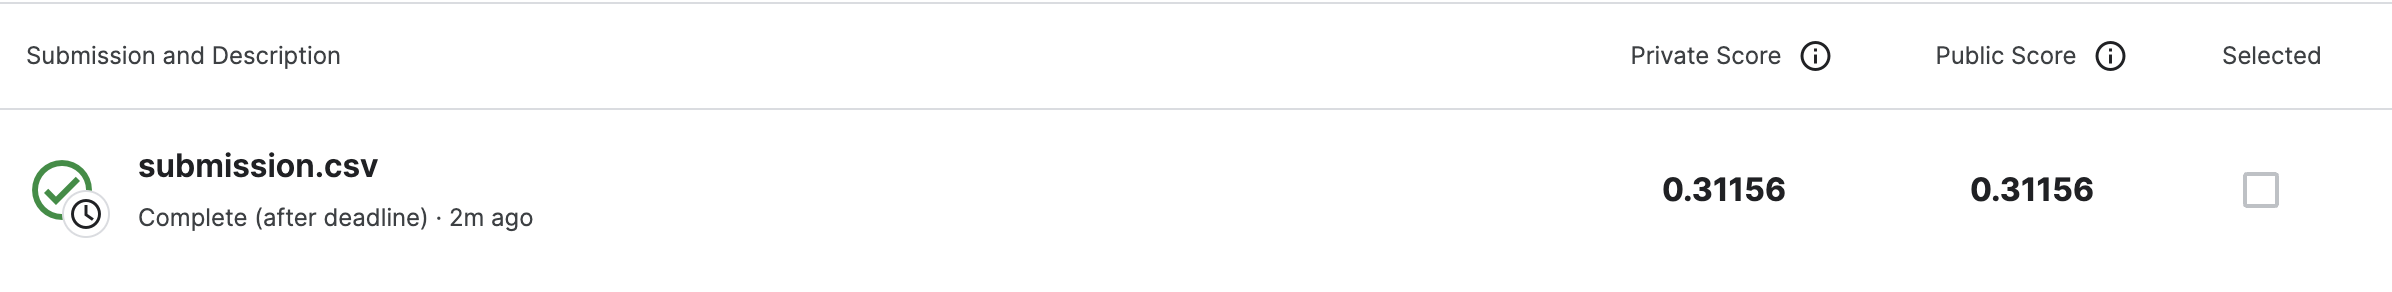

As compared to the train dataset the performance of the model on test dataset is really bad, next I will hypertune the model parameters for getting better results. 

### Hypertuning the Latent Feautres

I will try different number of compoments for the TruncatedSVD, and I will also calculate the Silhouette Score along wiht accuracy of the model to see if it is clustering the 5 categories effectively.

n_components: 5, Silhouette Score: 0.5791120618540897, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5795005789682584, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5784419515897723, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5772615877055589, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.579594720861615, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5789398565677085, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5789149174572994, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.579994627050836, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5779935815897554, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5771472593399399, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5788711620879848, Accuracy: 0.9214765100671141
n_components: 5, Silhouette Score: 0.5797187104886815, Accuracy: 0.92147651006

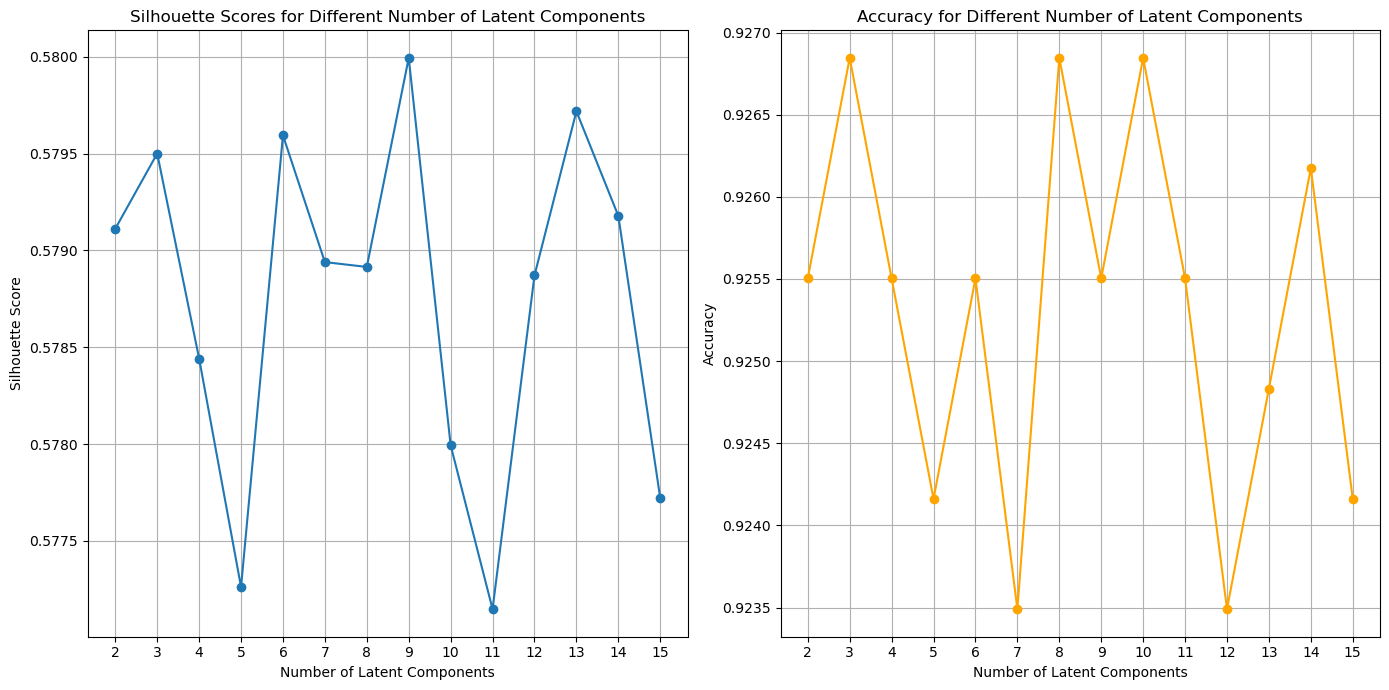

In [87]:
n_components_range = range(2, 16)
silhouette_scores = []
accuracy_scores = []

for n_components in n_components_range:
    n_components = bbc_news_data['Category'].nunique()
    lf_model = TruncatedSVD(n_components=n_components)
    lf_pipeline = make_pipeline(lf_model, Normalizer(copy=False))
    X_train_lf = lf_pipeline.fit_transform(X_train_tfidf)

    kmeans_model = KMeans(n_clusters=5, random_state=42, n_init=10)

    train_clusters = kmeans_model.fit_predict(X_train_lf)
    clusters = kmeans_model.labels_
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(bbc_news_data['Category'])

    mapped_labels = np.zeros_like(train_clusters)
    for i in range(5):
        mask = (train_clusters == i)
        mapped_labels[mask] = mode(true_labels[mask], keepdims=True)[0]

    train_accuracy = accuracy_score(true_labels, mapped_labels)

    silhouette_score_val = silhouette_score(X_train_lf, clusters)
    silhouette_scores.append(silhouette_score_val)
    accuracy_scores.append(train_accuracy)

    print(f"n_components: {n_components}, Silhouette Score: {silhouette_score_val}, Accuracy: {accuracy_val}")

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Latent Components')
plt.xlabel('Number of Latent Components')
plt.ylabel('Silhouette Score')
plt.xticks(n_components_range)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_components_range, accuracy_scores, marker='o', color='orange')
plt.title('Accuracy for Different Number of Latent Components')
plt.xlabel('Number of Latent Components')
plt.ylabel('Accuracy')
plt.xticks(n_components_range)
plt.grid(True)

plt.tight_layout()
plt.show()

The above visualization shows that n_components set to values higher/lower than 5 doesn't make a significant difference in either silhouette score (0.57 - 0.58) or the accuracy score (0.923 - 0.927), which remain approximately unchanged with respect to n_components = 5. Next let's try and chagne the N-clusters paramter of the K-Means model to see if it makes ahy difference.

### Hypertuning N-Clusters in the K-Means Model

n_clusters: 2, Silhouette Score: 0.3323222171515189, Accuracy: 0.9214765100671141
n_clusters: 3, Silhouette Score: 0.4019159524937347, Accuracy: 0.9214765100671141
n_clusters: 4, Silhouette Score: 0.489384693351667, Accuracy: 0.9214765100671141
n_clusters: 5, Silhouette Score: 0.5794633297028781, Accuracy: 0.9214765100671141
n_clusters: 6, Silhouette Score: 0.5489140074504449, Accuracy: 0.9214765100671141
n_clusters: 7, Silhouette Score: 0.5242884640758801, Accuracy: 0.9214765100671141
n_clusters: 8, Silhouette Score: 0.48552965518537355, Accuracy: 0.9214765100671141
n_clusters: 9, Silhouette Score: 0.4251693540898781, Accuracy: 0.9214765100671141
n_clusters: 10, Silhouette Score: 0.398121960437941, Accuracy: 0.9214765100671141
n_clusters: 11, Silhouette Score: 0.3797134899718554, Accuracy: 0.9214765100671141
n_clusters: 12, Silhouette Score: 0.3686994286030876, Accuracy: 0.9214765100671141
n_clusters: 13, Silhouette Score: 0.3466740774066873, Accuracy: 0.9214765100671141
n_clusters: 1

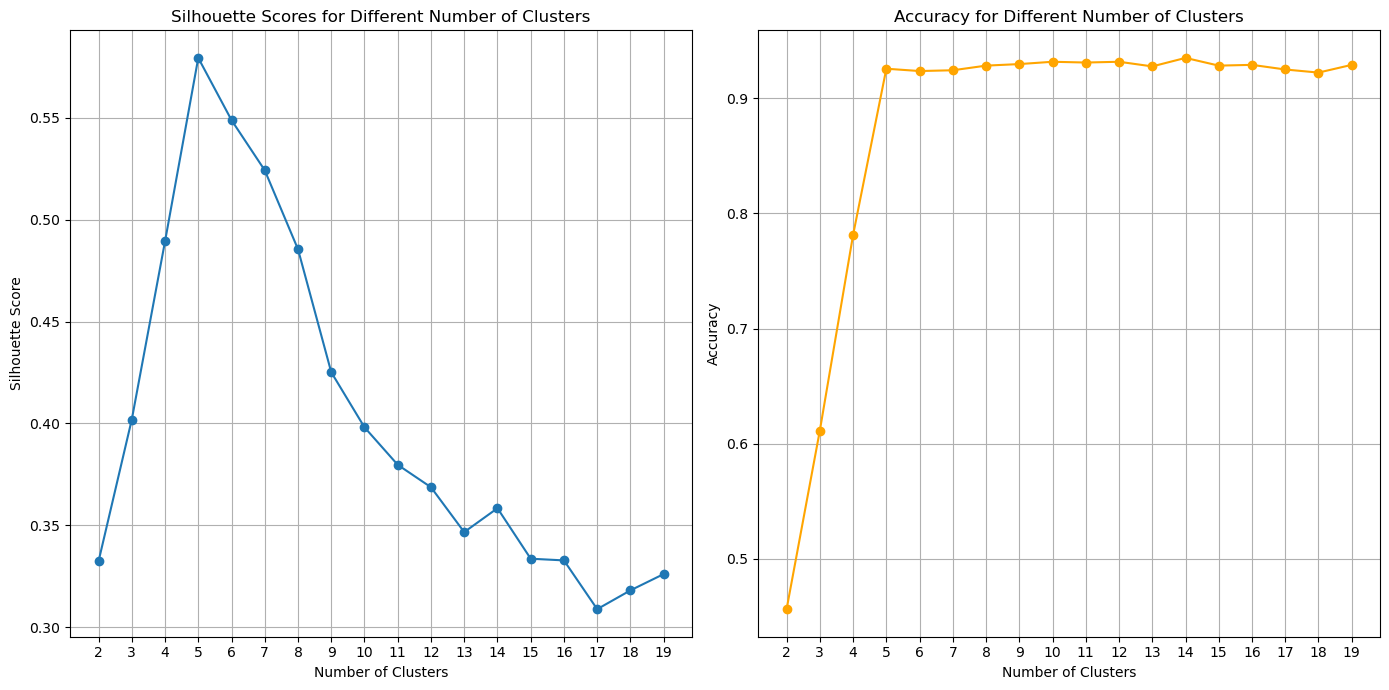

In [88]:
n_clusters_range = range(2, 20)
silhouette_scores = []
accuracy_scores = []

for n_cluster in n_clusters_range:
    n_components = bbc_news_data['Category'].nunique()
    lf_model = TruncatedSVD(n_components=5)
    lf_pipeline = make_pipeline(lf_model, Normalizer(copy=False))
    X_train_lf = lf_pipeline.fit_transform(X_train_tfidf)

    kmeans_model = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)

    train_clusters = kmeans_model.fit_predict(X_train_lf)
    clusters = kmeans_model.labels_
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(bbc_news_data['Category'])

    mapped_labels = np.zeros_like(train_clusters)
    for i in range(n_cluster):
        mask = (train_clusters == i)
        mapped_labels[mask] = mode(true_labels[mask], keepdims=True)[0]

    train_accuracy = accuracy_score(true_labels, mapped_labels)

    silhouette_score_val = silhouette_score(X_train_lf, clusters)
    silhouette_scores.append(silhouette_score_val)
    accuracy_scores.append(train_accuracy)

    print(f"n_clusters: {n_cluster}, Silhouette Score: {silhouette_score_val}, Accuracy: {accuracy_val}")

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(list(n_clusters_range))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, accuracy_scores, marker='o', color='orange')
plt.title('Accuracy for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.xticks(list(n_clusters_range))
plt.grid(True)

plt.tight_layout()
plt.show()

The accuracy reamins the same after the n_cluster reaches __5__ and the sihouette score drops after n_cluster > 5. So from the above hypertuning result we can conclude that the first model is the best model with n_cluster = 5 and latent compoents n_component = 5.  Next Let's try to fit a supervised lerning model to see how it performs.

## Supervised SVM Model

I will split the dataset into to train and test split to validate the model locally and then submit to kaggle. 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_tfidf, true_labels, test_size=0.2, random_state=42, stratify=true_labels
)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_report = classification_report(y_train, y_train_pred)
test_report = classification_report(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Training Classification Report:")
print(train_report)
print("Test Classification Report:")
print(test_report)

Training Accuracy: 0.9983221476510067
Test Accuracy: 0.9731543624161074
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       218
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       209

    accuracy                           1.00      1192
   macro avg       1.00      1.00      1.00      1192
weighted avg       1.00      1.00      1.00      1192

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        67
           1       0.96      1.00      0.98        55
           2       1.00      0.95      0.97        55
           3       0.99      1.00      0.99        69
           4       0.96      0.92      0.94        52

    accuracy                           0.97       298

The SVM model seems to perform well on the train and test split with a ~100% accuracy on training data and 97% accuracy on the local testdata.

### Kaggle Test Result

In [96]:
def generate_submission(model, vectorizer, test_filepath, sample_submission_filepath, output_filepath):
    test_data = pd.read_csv(test_filepath)
    X_test_tfidf = vectorizer.transform(test_data['Text'])
    test_labels = model.predict(X_test_tfidf)
    test_predictions = model.predict(X_test_tfidf)
    test_labels = label_encoder.inverse_transform(test_predictions)
    sample_submission = pd.read_csv(sample_submission_filepath)
    sample_submission['Category'] = test_labels
    sample_submission.to_csv(output_filepath, index=False)
    

test_filepath = './BBC News Test.csv'
sample_submission_filepath = './BBC News Sample Solution.csv'
output_filepath = './submission1.csv'
generate_submission(
    model=svm_model,
    vectorizer=tfidf_vectorizer,
    test_filepath= test_filepath,
    sample_submission_filepath=sample_submission_filepath,
    output_filepath=output_filepath
)

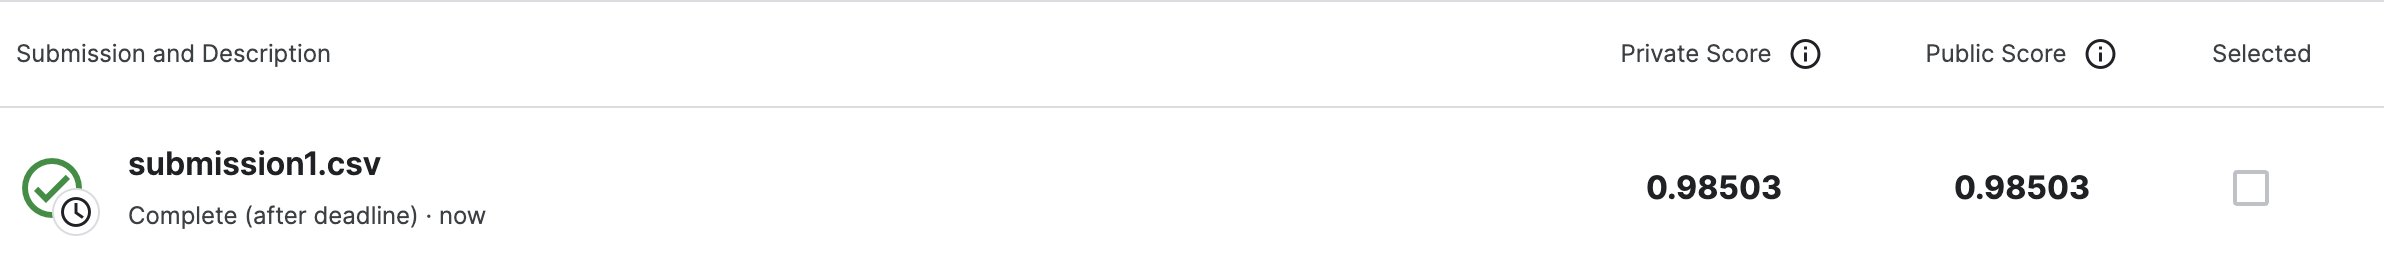

## Data Efficiency and Overfitting

I will measure the accuracy and time of the SVM and KMeans model on 20% and 50% of the dataset, to analyse Data Efficiency and Overfitting.

In [105]:
X_train_20, _, y_train_20, _ = train_test_split(X_train_tfidf, true_labels, train_size=0.2, random_state=42, stratify=true_labels)
X_train_50, _, y_train_50, _ = train_test_split(X_train_tfidf, true_labels, train_size=0.5, random_state=42, stratify=true_labels)

def evaluate_kmeans(X, y):
    start_time = time.time()
    kmeans = KMeans(n_clusters=5, random_state=42, n_init = 10)
    kmeans.fit(X)
    elapsed_time = time.time() - start_time
    clusters = kmeans.labels_
    mapped_labels = np.zeros_like(clusters)
    for cluster_id in range(kmeans.n_clusters):
        mask = (clusters == cluster_id)
        if np.any(mask):
            mapped_labels[mask] = mode(y[mask], keepdims = True)[0]
    silhouette = silhouette_score(X, clusters)
    accuracy = accuracy_score(y, mapped_labels)
    return silhouette, accuracy, elapsed_time

def evaluate_svm(X, y):
    start_time = time.time()
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X, y)
    elapsed_time = time.time() - start_time
    predictions = svm.predict(X)
    accuracy = accuracy_score(y, predictions)
    return accuracy, elapsed_time

silhouette_20, accuracy_kmeans_20, time_kmeans_20 = evaluate_kmeans(X_train_20, y_train_20)
accuracy_svm_20, time_svm_20 = evaluate_svm(X_train_20, y_train_20)

silhouette_50, accuracy_kmeans_50, time_kmeans_50 = evaluate_kmeans(X_train_50, y_train_50)
accuracy_svm_50, time_svm_50 = evaluate_svm(X_train_50, y_train_50)


#### Visualising the Result

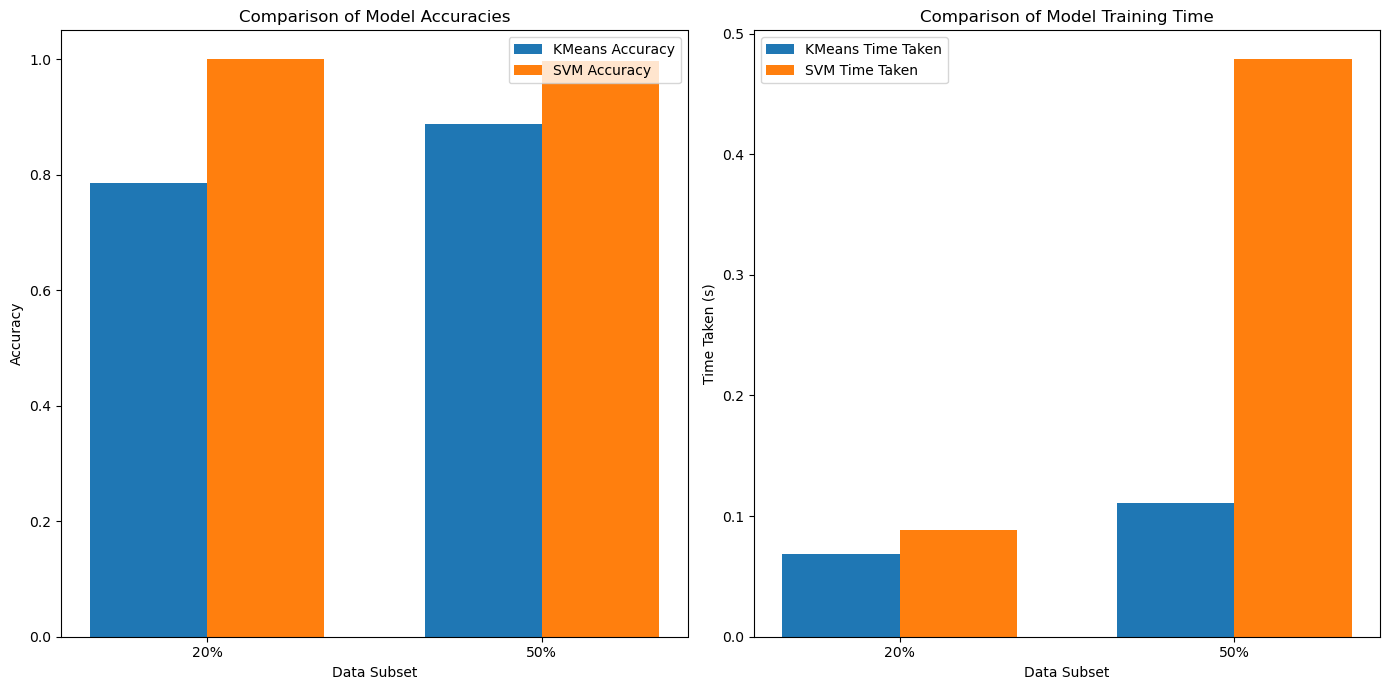

In [109]:
kmeans_results = {
    '20%': {'Silhouette Score': silhouette_20, 'Accuracy': accuracy_kmeans_20, 'Time Taken': time_kmeans_20},
    '50%': {'Silhouette Score': silhouette_50, 'Accuracy': accuracy_kmeans_50, 'Time Taken': time_kmeans_50}
}

svm_results = {
    '20%': {'Accuracy': accuracy_svm_20, 'Time Taken': time_svm_20},
    '50%': {'Accuracy': accuracy_svm_50, 'Time Taken': time_svm_50}
}

# Extract the data for plotting
subset_names = ['20%', '50%']
kmeans_accuracies = [kmeans_results[subset]['Accuracy'] for subset in subset_names]
svm_accuracies = [svm_results[subset]['Accuracy'] for subset in subset_names]
kmeans_times = [kmeans_results[subset]['Time Taken'] for subset in subset_names]
svm_times = [svm_results[subset]['Time Taken'] for subset in subset_names]

bar_width = 0.35
index = np.arange(len(subset_names))

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
bar1 = plt.bar(index, kmeans_accuracies, bar_width, label='KMeans Accuracy')
bar2 = plt.bar(index + bar_width, svm_accuracies, bar_width, label='SVM Accuracy')

plt.xlabel('Data Subset')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(index + bar_width / 2, subset_names)
plt.legend()

plt.subplot(1, 2, 2)
bar1 = plt.bar(index, kmeans_times, bar_width, label='KMeans Time Taken')
bar2 = plt.bar(index + bar_width, svm_times, bar_width, label='SVM Time Taken')

plt.xlabel('Data Subset')
plt.ylabel('Time Taken (s)')
plt.title('Comparison of Model Training Time')
plt.xticks(index + bar_width / 2, subset_names)
plt.legend()

plt.tight_layout()
plt.show()


## Data Efficiency

### KMeans:

With 20% of the data, the accuracy was approximately 78.52%.
With 50% of the data, the accuracy improved to approximately 88.72%.

### SVM:

With 20% of the data, the accuracy reached 100%.
With 50% of the data, the accuracy was slightly lower but still very high at approximately 99.73%.
The SVM model demonstrates a high degree of data efficiency, as it was able to achieve perfect or near-perfect accuracy with only 20% and 50% of the available training data. The KMeans model also showed improvement with more data but didn't reach the accuracy levels of the SVM.

The SVM model demonstrates a high degree of data efficiency, as it was able to achieve perfect or near-perfect accuracy with only 20% and 50% of the available training data. The KMeans model also showed improvement with more data and was faster than SVM for both data sizes but didn't reach the accuracy levels of the SVM.


## Overfitting

### KMeans:

This model is generally less prone to overfitting since it's an unsupervised learning algorithm and doesn't use the label information for training. The increase in accuracy with more data suggests that the model is learning useful patterns from the data.

### SVM:

The SVM reached an accuracy of 100% on the training data with just 20% of the data, which could be a sign of overfitting, especially if this accuracy is not reflected in the test results. However, the accuracy on the kaggle test data suggests that the model generalized well and that the high training accuracy was not solely due to overfitting.

## Conclusion

For the BBC News Classification I have tried the following models:


| Model        | Train Acc | Kaggle Acc |
|--------------|-----------|----------|
| K-Means Clustering  | 92%    | 31%   |
| K-Means Clustering with varying n-components : [2-15] | ~92%  | 31%   |
| K-Means Clustering with varying n-clusters : [2-20] | ~92%  | 31%   |
| Support Vector Machine  | 100%    | 98%   |
| K-Means Clustering with 20% data  | 78%   | |
| K-Means Clustering with 50% data  | 88%   | |
| SVM with 20% data  | 100%   | |
| SVM 50% data  | 99%   | |


# Movie Ratings Dataset - ( Part 2 of the Assignment )

Below I will use Non-Negative Matrix Factorization to predict the test ratings for the Movie Ratings Dataset. 

In [134]:
movies_df = pd.read_csv('movies.csv')
users_df = pd.read_csv('users.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_ratings_matrix = train_df.pivot(index='uID', columns='mID', values='rating')
train_ratings_matrix.fillna(0, inplace=True)

nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(train_ratings_matrix)
H = nmf.components_

predicted_ratings = np.dot(W, H)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_ratings_matrix.index, columns=train_ratings_matrix.columns)

test_df['predicted_rating'] = test_df.apply(
    lambda x: predicted_ratings_df.loc[x['uID'], x['mID']] 
    if x['uID'] in predicted_ratings_df.index and x['mID'] in predicted_ratings_df.columns 
    else np.nan, axis=1
)

average_rating = train_df['rating'].mean()
test_df['predicted_rating'].fillna(average_rating, inplace=True)

rmse = sqrt(mean_squared_error(test_df['rating'], test_df['predicted_rating']))
print('RMSE:', rmse)

RMSE: 2.9911877907526


The underperformance of sklearn's non-negative matrix factorization (NMF) with an RSME of __2.99__ on the movie ratings dataset compared to simple baselines or similarity-based methods could be due to factors like data sparsity and suboptimal hyperparameter settings. Improving NMF's performance could involve hyperparameter tuning, augmenting the model with additional user or item information, feature engineering, and ensemble methods. It's also worth considering alternative evaluation metrics such as ranking-based measures, to ensure a comprehensive assessment of the model's recommendation quality.